In [1]:
import pickle
import glob
import numpy as np

In [2]:
from sklearn.utils import shuffle

WINDOW=15

def append(a,b):
    if b is None:
        return a
    if a is None:
        a=b
    else:
        a=np.concatenate((a,b))
    return a

def get_XY():
    path = './*.bin'
    files = glob.glob(path)
    X = None
    y = None
    
    for j in range(len(files)):
        f = files[j]
        with open(f, 'rb') as fp:
            signal = pickle.load(fp)
        xi = None
        for example in signal:
            data = None
            for i in range(len(example)-WINDOW):
                chunk = np.array(example[i:i+WINDOW])
                chunk = chunk[None,:]
                data = append(data, chunk)
            if(len(example) < WINDOW):
                chunk = np.array(example)
                rem = WINDOW - len(chunk)
                data = np.concatenate((chunk, np.random.choice(chunk, rem)))
                data = data[None,:]
            xi = append(xi, data)
        yi = np.ones(xi.shape[0]) * j
        X = append(X, xi)
        y = append(y, yi)
    
    return shuffle(X, y)

X,y = get_XY()
print(X.shape, y.shape)

(25616, 15) (25616,)


Text(0.5, 1.0, 'Class Distribution (count)')

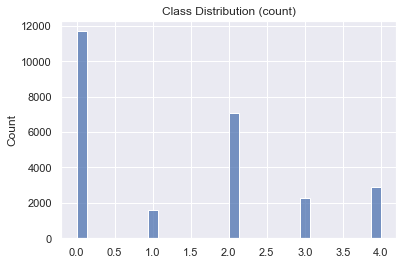

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.plot()
sns.histplot(y)
plt.title('Class Distribution (count)')

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

dev = torch.device('cpu')
BATCH_SIZE = 1024
BATCH_SIZE_TRAIN = 1024

def get_loader(dev, X, y):
    print(X.shape)
    target = torch.tensor(y)
    target = target.type(torch.LongTensor)
    data = torch.tensor(X).float()
    tensor = torch.utils.data.TensorDataset(data.to(dev), target.to(dev))
    loader = torch.utils.data.DataLoader(dataset=tensor, batch_size=BATCH_SIZE, shuffle=False,
                                        pin_memory=True)
    return loader

def init_weights(m):
    if type(m)==nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        
def train_model(curr_model, Loader, epochs=100, verbose=True, rnn=False, lr=.005):
    
    optimizer = torch.optim.AdamW(curr_model.parameters(), lr=lr)
    loss_func = nn.CrossEntropyLoss()
    curr_model.apply(init_weights)
    
    loss_hist=[]
    acc_hist=[]
    
    for e in range(epochs):
        running_loss = 0
        correct = 0
        total = 0
        for params, labels in Loader:
            labels = labels.squeeze().type(torch.LongTensor)
            optimizer.zero_grad()
            prediction = curr_model(params.to(dev))
            class_preds = torch.argmax(prediction, dim=1)
            correct += torch.sum(class_preds == labels)
            loss = loss_func(prediction, labels)
            total += labels.shape[0]
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss = running_loss/len(Loader)
        acc = correct / total
        loss_hist.append(loss)
        acc_hist.append(acc)
        if verbose and (e%20==0 or e==epochs-1):
            print(f'EPOCH:{e}')
            print(f'  Training loss: {loss}')
            print(f'  Accuracy: {acc}')
    return [acc_hist, loss_hist]
                  
def get_acc(Loader, model, dev):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for params, labels in Loader:
            labels = labels.squeeze().type(torch.LongTensor)
            preds = model(params.to(dev))
            class_preds = torch.argmax(preds, dim=1)
            correct += torch.sum(class_preds == labels)
            total += len(labels)
    return correct/total

def get_predictions(Loader, model, dev):
    model.eval()
    y = None
    with torch.no_grad():
        for params, labels in Loader:
            preds = model(params.to(dev))
            class_preds = torch.argmax(preds, dim=1)
            preds = class_preds.detach().cpu().numpy()
            y = append(y, preds)
    return y

class LinearModule(nn.Module):
    def __init__(self, in_nodes=5, out_nodes=5, dropout=.2):
        super(LinearModule, self).__init__()
        self.dropout = dropout
        self.lin = nn.Linear(in_nodes, out_nodes)
        
    def forward(self, x):
        x = F.leaky_relu(self.lin(x))
        return F.dropout(x, self.dropout)
    
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, nodes=10, dropout=.2, total_layers=2):
        super(ANN, self).__init__()
        self.nodes = nodes
        self.drp = dropout
        self.input_dim = input_dim
        self.total_layers = total_layers
        self.output_dim = output_dim
        self.buildModel()
        
    def buildModel(self):
        lin1 = LinearModule(self.input_dim, self.nodes, self.drp)
        self.lin_out = nn.Linear(self.nodes, self.output_dim)
        self.lins = nn.ModuleList([lin1])
        for i in range(self.total_layers-1):
            self.lins.append(LinearModule(self.nodes,self.nodes,self.drp))
            
    def forward(self, x):
        for i, l in enumerate(self.lins):
            x = l(x)
        x = self.lin_out(x)
        return x

In [19]:
loader = get_loader(dev, X, y)

model = ANN(WINDOW,5,100,.2,5)
hist = train_model(model, loader, 100, True)

(25616, 15)
EPOCH:0
  Training loss: 1.6080253995381868
  Accuracy: 0.4207916855812073


KeyboardInterrupt: 

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, layers):
        super(LSTM, self).__init__()

        self.hidden_dim= hidden_dim
        self.layers=layers

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=layers, batch_first=True)
        self.lin = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        batch_size = x.size(0)
        state = self.init_hidden(batch_size)

        out, state = self.lstm(x.view(len(x) ,1, -1), state)
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.lin(out)
        return out
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layers, batch_size, self.hidden_dim)
        cell = torch.zeros(self.layers, batch_size, self.hidden_dim)
        return hidden, cell

In [34]:
loader = get_loader(dev, X, y)
model = LSTM(WINDOW,5,5,2)
hist = train_model(model, loader, 100, True)

(30980, 7)
EPOCH:0
  Training loss: 1.5458008627737723
  Accuracy: 0.34189799427986145
EPOCH:20
  Training loss: 1.334151591024091
  Accuracy: 0.4334409236907959
EPOCH:40
  Training loss: 1.3224576673200052
  Accuracy: 0.4368624985218048
EPOCH:60
  Training loss: 1.3175366078653643
  Accuracy: 0.4378308653831482
EPOCH:80
  Training loss: 1.3121078552738312
  Accuracy: 0.43576499819755554
EPOCH:99
  Training loss: 1.2892811682916456
  Accuracy: 0.4507424235343933


In [4]:
class CNN(nn.Module):
    def __init__(self, conv_dim):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(conv_dim, 64, 9, padding=5)
        self.conv2 = nn.Conv1d(64, 32, 7, padding=3)
        self.conv3 = nn.Conv1d(32, 64, 7, padding=3)
        self.conv4 = nn.Conv1d(64, 32, 5, padding=2)
        self.conv5 = nn.Conv1d(32, 64, 5, padding=2)
        self.conv6 = nn.Conv1d(64, 32, 3, padding=1)
        self.conv7 = nn.Conv1d(32, 64, 3, padding=1)
        self.conv8 = nn.Conv1d(64, 5, 3)
        
        self.flat = nn.Flatten()
        self.dense = nn.Linear((WINDOW)*5, 5)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.relu(out)
        
        residual = out
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        out = self.relu(out)
        residual = out
        
        out = self.conv4(out)
        out = self.relu(out)
        out = self.conv5(out)
        out += residual
        out = self.relu(out)
        residual = out
        
        out = self.conv6(out)
        out = self.relu(out)
        out = self.conv7(out)
        out = self.relu(out)
        out = self.conv8(out)
        
        out = self.flat(out)
        out, self.dense(out)
        
        return out

In [48]:
loader = get_loader(dev, X[:,None,:], y)
model = CNN(1)
hist = train_model(model, loader, 300, True)

(28700, 1, 10)
EPOCH:0
  Training loss: 1.9996077315560703
  Accuracy: 0.3558885157108307
EPOCH:20
  Training loss: 1.162961731696951
  Accuracy: 0.5143554210662842
EPOCH:40
  Training loss: 1.0968344725411514
  Accuracy: 0.5330662131309509
EPOCH:60
  Training loss: 1.0506199053649246
  Accuracy: 0.5515679717063904
EPOCH:80
  Training loss: 1.0271060179019798
  Accuracy: 0.5629616975784302
EPOCH:100
  Training loss: 0.9826560010170114
  Accuracy: 0.5742856860160828
EPOCH:120
  Training loss: 0.9675571497144371
  Accuracy: 0.5806968808174133
EPOCH:140
  Training loss: 0.9369249266797098
  Accuracy: 0.5953658819198608
EPOCH:160
  Training loss: 0.9299398249593275
  Accuracy: 0.5978397130966187
EPOCH:180
  Training loss: 0.8958633336527594
  Accuracy: 0.6108362078666687
EPOCH:200
  Training loss: 0.8890607444376781
  Accuracy: 0.6116724610328674
EPOCH:220
  Training loss: 0.887306677884069
  Accuracy: 0.6127177476882935
EPOCH:240
  Training loss: 0.8696528226137161
  Accuracy: 0.618780493

In [45]:
class CNN_LSTM(nn.Module):
    def __init__(self, conv_dim, input_dim, output_dim, hidden_dim, layers):
        super(CNN_LSTM, self).__init__()
        
        self.embedded_dim = WINDOW
        self.layers = layers
        self.hidden_dim = hidden_dim
        
        self.conv1 = nn.Conv1d(conv_dim, 64, 9, padding=5)
        self.conv2 = nn.Conv1d(64, 32, 7, padding=3)
        self.conv3 = nn.Conv1d(32, 64, 7, padding=3)
        self.conv4 = nn.Conv1d(64, 32, 5, padding=2)
        self.conv5 = nn.Conv1d(32, 64, 5, padding=2)
        self.conv6 = nn.Conv1d(64, 32, 3, padding=1)
        self.conv7 = nn.Conv1d(32, 64, 3, padding=1)
        self.conv8 = nn.Conv1d(64, 1, 3)
        
        self.flat = nn.Flatten()
        self.lstm = nn.LSTM(input_size=self.embedded_dim, hidden_size=hidden_dim,
                            num_layers=layers, batch_first=True)
        self.dense = nn.Linear(hidden_dim, 5)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        batch_size = x.size(0)
        state = self.init_hidden(batch_size)
        
        out = self.conv1(x)
        out = self.relu(out)
        
        residual = out
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out += residual
        out = self.relu(out)
        residual = out
        
        out = self.conv4(out)
        out = self.relu(out)
        out = self.conv5(out)
        out += residual
        out = self.relu(out)
        residual = out
        
        out = self.conv6(out)
        out = self.relu(out)
        out = self.conv7(out)
        out = self.relu(out)
        out = self.conv8(out)
        
        #out = self.flat(out)
        out, state = self.lstm(out, state)
        out = self.dense(out)
        return out.view(out.size(0),-1)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layers, batch_size, self.hidden_dim)
        cell = torch.zeros(self.layers, batch_size, self.hidden_dim)
        return hidden, cell

In [46]:
loader = get_loader(dev, X[:,None,:], y)
model = CNN_LSTM(1, WINDOW, 5, 25, 2)
hist = train_model(model, loader, 100, True)

(28700, 1, 10)
EPOCH:0
  Training loss: 1.4222643375396729
  Accuracy: 0.41630661487579346
EPOCH:20
  Training loss: 1.3796735632008519
  Accuracy: 0.4404181241989136
EPOCH:40
  Training loss: 1.3795518957335373
  Accuracy: 0.4404181241989136
EPOCH:60
  Training loss: 1.379414155565459
  Accuracy: 0.4404181241989136
EPOCH:80
  Training loss: 1.3793061642811215
  Accuracy: 0.4404181241989136
EPOCH:100
  Training loss: 1.379237964235503
  Accuracy: 0.4404181241989136
EPOCH:120
  Training loss: 1.3817081122562802
  Accuracy: 0.4404181241989136
EPOCH:140
  Training loss: 1.3789888250416722
  Accuracy: 0.4404181241989136
EPOCH:160
  Training loss: 1.3726030012656902
  Accuracy: 0.4417421519756317


KeyboardInterrupt: 

In [15]:
!jt -t chesterish
preds = get_predictions(test_loader, model, dev)
preds.shape

'jt' is not recognized as an internal or external command,
operable program or batch file.


NameError: name 'test_loader' is not defined

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y, preds))

NameError: name 'preds' is not defined

In [5]:
from sklearn.metrics import classification_report

def train_and_test(i, X_l, y_l):
    X_train = None
    X_test = None
    y_train = None
    y_test = None
    for j in range(len(X_l)):
        if i==j:
            X_test = X_l[j]
            y_test = y_l[j]
        else:
            X_train = append(X_train, X_l[j])
            y_train = append(y_train, y_l[j])
    return X_train, X_test, y_train, y_test


def cross_val(X, y):
    chunk_size = X.shape[0]//5
    X_chunks = []
    y_chunks = []
    for i in range(4):
        X_chunks.append(X[i*chunk_size:(i+1)*chunk_size,...])
        y_chunks.append(y[i*chunk_size:(i+1)*chunk_size,...])
    X_chunks.append(X[(i+1)*chunk_size:,...])
    y_chunks.append(y[(i+1)*chunk_size:,...])
    
    accs = []
    for i in range(5):
        X_train, X_test, y_train, y_test = train_and_test(i, X_chunks, y_chunks)
        train_loader = get_loader(dev, X_train[:,None,:], y_train)
        test_loader = get_loader(dev, X_test[:,None,:], y_test)
        model = CNN(1)
        train_model(model, train_loader, 150, True)
        preds = get_predictions(test_loader, model, dev)
        acc = get_acc(test_loader, model, dev)
        print(acc)
        accs.append(acc)
        print(classification_report(y_test, preds))
    print(accs)
    return accs

In [6]:
accs = cross_val(X, y)

(20493, 1, 15)
(5123, 1, 15)
EPOCH:0
  Training loss: 2.4936398438044955
  Accuracy: 0.32645294070243835
EPOCH:20
  Training loss: 1.143779490675245
  Accuracy: 0.5206655859947205
EPOCH:40
  Training loss: 1.0554349252155848
  Accuracy: 0.551895797252655
EPOCH:60
  Training loss: 0.9519035688468388
  Accuracy: 0.5875176787376404
EPOCH:80
  Training loss: 0.9240421837284452
  Accuracy: 0.6023032069206238
EPOCH:100
  Training loss: 0.8272391330628168
  Accuracy: 0.6360708475112915
EPOCH:120
  Training loss: 0.8043849070866903
  Accuracy: 0.6428536772727966
EPOCH:140
  Training loss: 0.775703815477235
  Accuracy: 0.6563704609870911
EPOCH:149
  Training loss: 0.7622901367999259
  Accuracy: 0.6632508635520935
tensor(0.5655)
              precision    recall  f1-score   support

         0.0       0.61      0.75      0.67      2347
         1.0       0.42      0.19      0.26       322
         2.0       0.51      0.58      0.54      1353
         3.0       0.39      0.17      0.23       499


C:\Users\Luke\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


EPOCH:0
  Training loss: 2.184279038792565
  Accuracy: 0.33801785111427307
EPOCH:20
  Training loss: 1.0878873211996896
  Accuracy: 0.5444297790527344
EPOCH:40
  Training loss: 0.9654574422609239
  Accuracy: 0.589030385017395
EPOCH:60
  Training loss: 0.866929924204236
  Accuracy: 0.6213828921318054
EPOCH:80
  Training loss: 0.7744366086664654
  Accuracy: 0.6593471169471741
EPOCH:100
  Training loss: 0.7374096615683465
  Accuracy: 0.6762309074401855
EPOCH:120
  Training loss: 0.6629457949172883
  Accuracy: 0.7099009156227112
EPOCH:140
  Training loss: 0.6010368714729944
  Accuracy: 0.7352266907691956
EPOCH:149
  Training loss: 0.6504952744359062
  Accuracy: 0.7120968103408813
tensor(0.5626)
              precision    recall  f1-score   support

         0.0       0.64      0.69      0.66      2320
         1.0       0.42      0.22      0.29       343
         2.0       0.53      0.54      0.54      1447
         3.0       0.32      0.26      0.29       424
         4.0       0.51      

In [7]:
np.mean(accs)

0.55336434

In [8]:
pre = {0:[.61, .60, .63, .64, .63], 1:[.42, .33, .39, .42, .38], 2:[.51, .52, .51, .53, .53], 
       3:[.39, .34, .28, .32, .41], 4:[.61, .55, .39, .51, .55]}
rec = {0:[.75, .76, .62, .69, .74], 1:[.19, .20, .33, .22, .31], 2:[.58, .51, .44, .54, .54],
       3:[.17, .16, .26, .26, .19], 4:[.36, .29, .58, .51, .40]}
f1 = {0:[.67, .67, .62, .66, .68], 1:[.26, .25, .36, .29, .34], 2:[.54, .52, .47, .54, .53],
      3:[.23, .22, .27, .29, .26], 4:[.46, .38, .47, .51, .46]}

for i in range(5):
    print(i)
    print(f'  Precision: {np.mean(pre[i])}')
    print(f'  Recall: {np.mean(rec[i])}')
    print(f'  F1: {np.mean(f1[i])}')

0
  Precision: 0.622
  Recall: 0.712
  F1: 0.66
1
  Precision: 0.388
  Recall: 0.25
  F1: 0.3
2
  Precision: 0.5200000000000001
  Recall: 0.522
  F1: 0.5200000000000001
3
  Precision: 0.348
  Recall: 0.20800000000000002
  F1: 0.254
4
  Precision: 0.522
  Recall: 0.42800000000000005
  F1: 0.45600000000000007
